In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cross_validation as cv

from sklearn.cross_validation import KFold

from joblib import Parallel, delayed

from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier

In [49]:
df = pd.read_csv("./spam.train.txt", delim_whitespace=True, header=None)
x_data = df.ix[:, 1:].as_matrix(); y_data = df.ix[:, 0].as_matrix()
y_data[y_data == 0] = -1
x_train, x_test, y_train, y_test = cv.train_test_split(x_data, y_data,
                                                       test_size=0.25, random_state=288)

In [8]:
from src.benchmark import fset2scores

In [87]:
ada_best_params = {'n_estimators': 250, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}

def predict_on_fsubset(features, x_train, x_test, y_train, y_test):
    clf = AdaBoostClassifier(**ada_best_params)
    clf.fit(x_train[:, features], y_train)
    y_pred = clf.predict(x_test[:, features])
    score = f1_score(y_test, y_pred)
    return (clf, score)

In [88]:
def fset2scores(fset, x_train, x_test, y_train, y_test):    
    fpacks = [fset[:i] for i in range(1, len(fset)+1)]
    res = Parallel(n_jobs=8)(delayed(predict_on_fsubset)(pack, x_train, x_test, y_train, y_test) for pack in fpacks)
    
    clfs, scores = zip(*res)
    return clfs, scores

# CFS

In [9]:
from src.cfs import cfs, cfs1

### cfs1

In [10]:
cfs1_features = cfs1(x_train, y_train, x_train.shape[1])

In [22]:
cfs1_clfs, cfs1_scores, cfs1_times = fset2scores(cfs1_features, x_train, x_test, y_train, y_test)

In [31]:
from src.benchmark import plot_graph

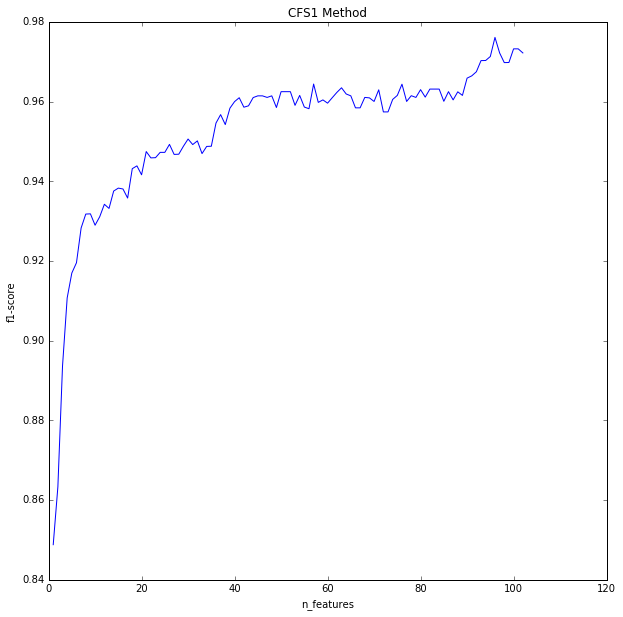

In [32]:
plot_graph(cfs1_scores, 'CFS1 Method', 'n_features', 'f1-score')

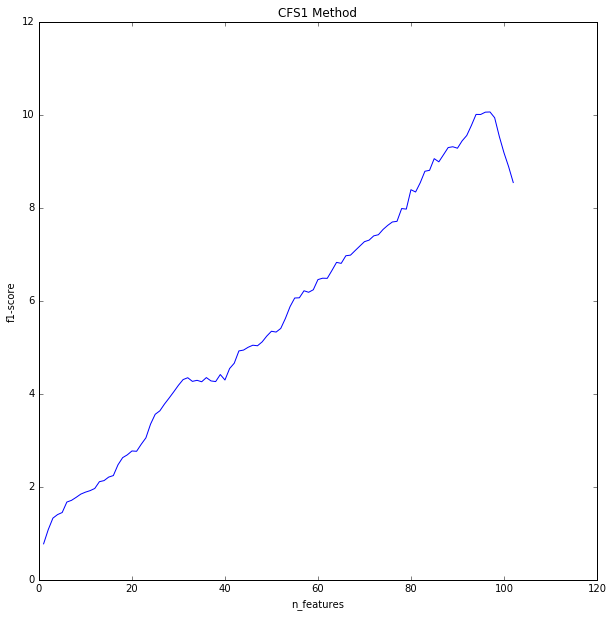

In [20]:
cfs_figure = plt.figure(figsize=(10, 10))
plt.plot(range(1, len(cfs1_features)+1), cfs1_scores)
plt.title('CFS1 Method')

plt.xlabel('n_features')
plt.ylabel('f1-score')
cfs_figure.savefig('./hw2_files/cfs_method_score.png')

### cfs2

In [100]:
cfs

<function src.cfs.cfs>

In [95]:
cfs_features = cfs(x_train, y_train, 1000)

In [99]:
cfs_features

[48,
 8,
 70,
 10,
 49,
 101,
 53,
 52,
 76,
 32,
 31,
 75,
 73,
 19,
 56,
 4,
 80,
 9,
 100,
 35,
 71,
 86,
 61,
 41,
 72]

In [97]:
cfs_clfs, cfs_scores, cfs_times  = fset2scores(cfs_features, x_train, x_test, y_train, y_test)

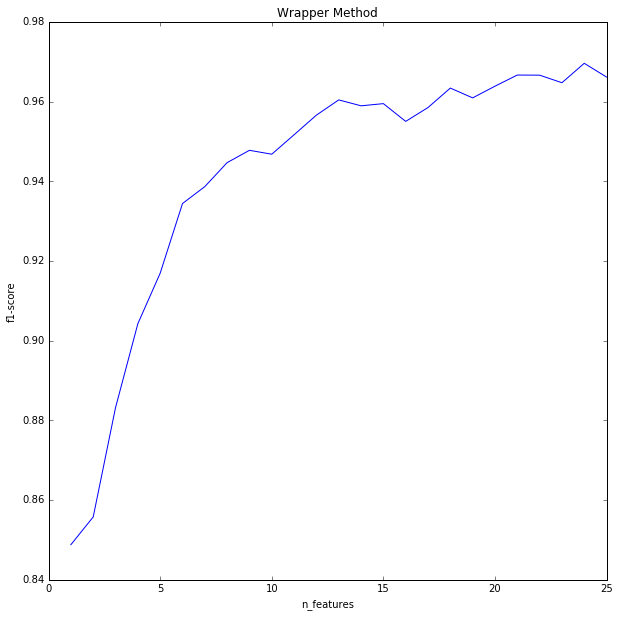

In [98]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, len(cfs_features)+1), cfs_scores)
plt.title('Wrapper Method')

plt.xlabel('n_features')
plt.ylabel('f1-score')

# Wrapper

In [57]:
from src.wrapper import wrapper

In [63]:
wrapper_features, wrapper_scores, wrapper_times = wrapper(2, x_train, y_train, x_test, y_test)

 0 1


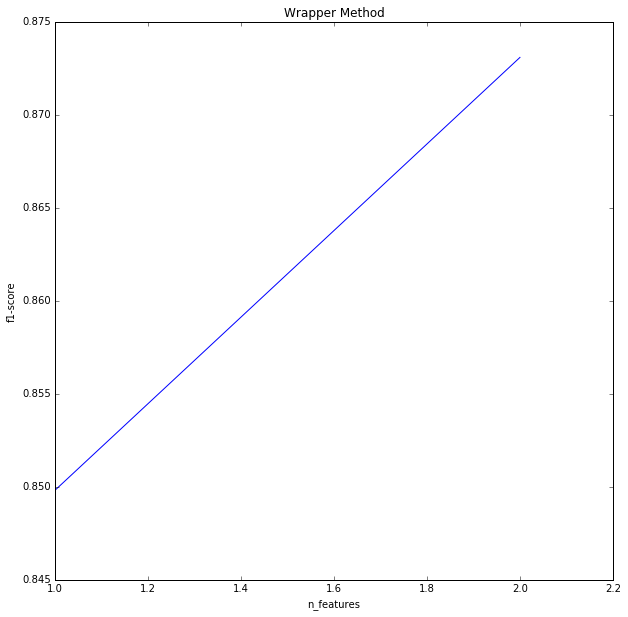

In [78]:
plot_graph(wrapper_scores, "Wrapper Method", "n_features", "f1-score", "./hw2_files/wrapper.png")

In [55]:
FOLDS = 4

ada_best_params = {'n_estimators': 250, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}


def fit_pred_abc(X, y, feature_set):
    score = 0
    
    
    for train_index, test_index in KFold(len(y), n_folds=FOLDS):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        abc = AdaBoostClassifier(*ada_best_params)
        abc.fit(X_train[:, feature_set], y_train)

        y_pred = abc.predict(X_test[:, feature_set])
        score += f1_score(y_test, y_pred)/float(FOLDS)
        
    return score

In [56]:
def wrapper(expected_features, x_train, y_train, x_test, y_test):
    initial_fset = set(np.arange(x_train.shape[1]))
    target_flist = list()
    times_list = []
    
    scores = []

    for i in range(expected_features):
        start = time.time()
        print i,
        target_fset = set(target_flist)
        rest_fset = list(initial_fset - target_fset)
        
        unbound_fsets = [list(target_fset|set([f])) for f in rest_fset]
        
#         clfs = Parallel(n_jobs=8)(delayed(fit_abc)(x_train[:, fset], y_train) for fset in unbound_fsets)
#         clfs_scores = [f1_score(y_test, clf.predict(x_test[:, unbound_fsets[i]])) for i, clf in enumerate(clfs)]
#         clfs_scores = Parallel(n_jobs=8)(delayed(fit_pred_abc)(x_train, y_train, fset) for fset in unbound_fsets)
        clfs_scores = [fit_pred_abc(x_train, y_train, fset) for fset in unbound_fsets]

        best_f_ind = np.argmax(clfs_scores)

        best_f = rest_fset[best_f_ind]
        target_flist.append(best_f)
        scores.append(clfs_scores[best_f_ind])
        end = time.time()
        times_list.append(end-start)

    return target_flist, scores, times_list

wrapper_features, wrapper_scores,wrapper_times  = wrapper(2, x_train, y_train, x_test, y_test)

0

TypeError: AdaBoostClassifier with algorithm='SAMME.R' requires that the weak learner supports the calculation of class probabilities with a predict_proba method.
Please change the base estimator or set algorithm='SAMME' instead.

In [133]:
wrapper_features, wrapper_scores, wrapper_times

([48, 53],
 [0.84981641438383315, 0.86643828578385995],
 [37.77843117713928, 39.939043045043945])

In [130]:
wrapper_features, wrapper_scores, wrapper_times

([48, 53],
 [0.84981641438383315, 0.86643828578385995],
 [8.948410987854004, 8.625895023345947])

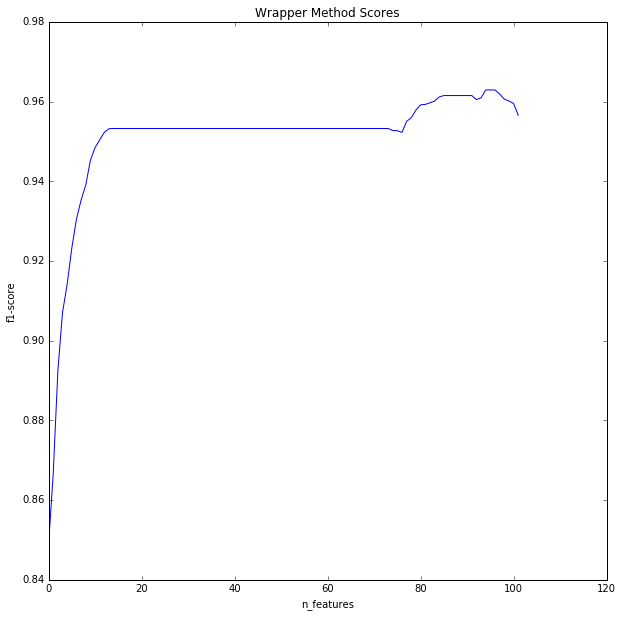

In [103]:
wrapper_fig = plt.figure(figsize=(10, 10))
plt.plot(range(len(wrapper_features)), wrapper_scores)
plt.title('Wrapper Method Scores')

plt.xlabel('n_features')
plt.ylabel('f1-score')
wrapper_fig.savefig('wrapper_method_scores.png')

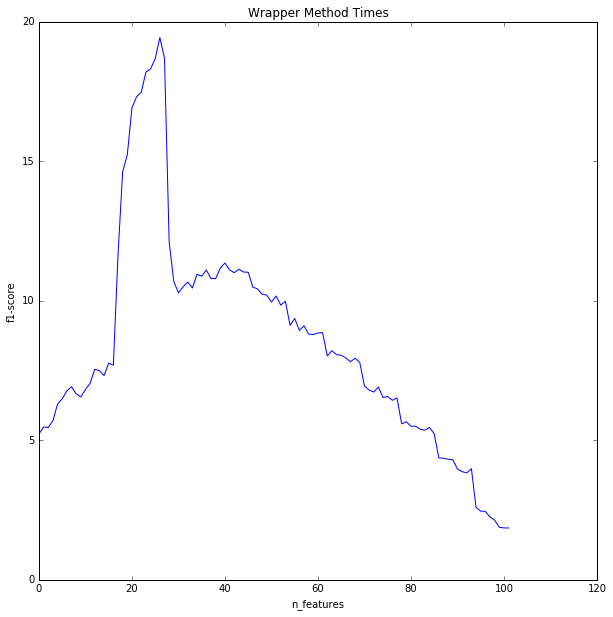

In [104]:
wrapper_fig = plt.figure(figsize=(10, 10))
plt.plot(range(len(wrapper_features)), wrapper_times)
plt.title('Wrapper Method Times')

plt.xlabel('n_features')
plt.ylabel('f1-score')
wrapper_fig.savefig('wrapper_method_times.png')

In [ ]:
len(cfs_features)

In [ ]:
len(wrapper_features)

# Embedded

In [ ]:
f_w = np.zeros(x_train.shape[1])

def wide_walk(tree, feature_weigths):
    if tree.split_feature is None:
        return feature_weigths
    
    feature_weigths[tree.split_feature] += tree.score
    
    feature_weigths = wide_walk(tree.fb, feature_weigths)
    feature_weigths = wide_walk(tree.tb, feature_weigths)
    
    return feature_weigths
wide_walk(gboost.ensembles[3].tree, f_w)
#np.sum(np.array([wide_walk(p.tree, np.zeros(x_train.shape[1])) for p in predictors[0].ensembles]), axis=0)

In [111]:
wrapper_features = np.array([48, 70, 53, 35, 101, 14, 47, 31, 42, 9, 11, 18, 33, 79, 37, 36, 54, 77, 39, 76, 2, 96, 51, 44, 71, 34, 58, 60, 97, 1, 64, 4, 55, 41, 85, 80, 65, 98, 67, 68, 45, 25, 99, 69, 6, 57, 73, 29, 56, 46, 66, 61, 7, 24, 89, 27, 43, 20, 22, 88, 32, 0, 86, 40, 3, 63, 62, 52, 15, 26, 95, 10, 21, 94, 75, 82, 87, 91, 100, 84, 50, 90, 28, 81, 92, 12, 83, 13, 17, 30, 19, 72, 93, 16, 49, 5, 23, 78, 59, 74, 38])

In [112]:
wrapper_scores = np.array([0.84980279445833762, 0.87067597774484895, 0.89346265274933079, 0.91357377066143086, 0.9270496053997106, 0.93802544847196712, 0.94457091901768786, 0.95002164718914828, 0.95316889946962047, 0.95692920680186444, 0.95779004539937529, 0.95859102027614029, 0.95936205669241104, 0.96130765861884337, 0.96281553377143902, 0.96326107023901364, 0.96320223841678354, 0.96369993935811715, 0.9637363071633287, 0.96386184687288012, 0.9646598067365264, 0.96483397223237666, 0.96477379693918908, 0.96576632323144485, 0.96621598546517462, 0.96669978948302315, 0.96669031759747392, 0.96669031759747392, 0.96669031759747392, 0.96669031759747392, 0.96654055540999773, 0.96640613833075162, 0.96641816342629605, 0.96675042920972154, 0.96739464964356192, 0.96837415995461917, 0.96853480720982499, 0.96851465562864014, 0.96836530576859992, 0.96836530576859992, 0.96835369839462992, 0.96855600819342769, 0.96805666102266086, 0.96792448655113383, 0.96838789893438082, 0.96823870388782951, 0.96853576258756502, 0.96935690879907899, 0.96972429589261533, 0.97071190681539798, 0.97087238405789433, 0.97061165751857914, 0.97070001971021735, 0.97076884196477753, 0.97153476329522093, 0.97189465541142916, 0.971571444624862, 0.97122866303493782, 0.97236960584480703, 0.97156671607728895, 0.97206917971939255, 0.97144631889298116, 0.97259536169410676, 0.97195185054455258, 0.97220620905576949, 0.9716899004526347, 0.97187869634345081, 0.97205182332953177, 0.97319006503398198, 0.97318506757711387, 0.97278208587924819, 0.97364422776795578, 0.97346764891636695, 0.97315616971961849, 0.97346969872001787, 0.97357941323597008, 0.97393717495297394, 0.97362608458122091, 0.97359518125063604, 0.97373866065535575, 0.97375339065755018, 0.97408229138496283, 0.97438110999442984, 0.97455794475476887, 0.97408510574634488, 0.97391695127819322, 0.97423806030631344, 0.97423806030631344, 0.97358678895786421, 0.97357374415074349, 0.97323092136274403, 0.97343598359629435, 0.97307950054697512, 0.97264650635775907, 0.97198679916175956, 0.97225709638348912, 0.9727732596699239, 0.97196354528018292, 0.97199421711088907, 0.97258572046886482, 0.97135166824126284])

In [113]:
wrapper_times = np.array([9.835294961929321, 11.343223094940186, 12.702066898345947, 14.217800855636597, 16.527595043182373, 20.23885202407837, 24.428974866867065, 27.534098863601685, 31.15582299232483, 30.964584827423096, 34.52835488319397, 38.81583285331726, 42.78717112541199, 43.07756590843201, 41.525052070617676, 43.06470799446106, 44.48232698440552, 45.31823396682739, 45.38195610046387, 49.20027184486389, 49.56662106513977, 52.83546018600464, 51.77622199058533, 51.3133590221405, 52.52103590965271, 54.10197401046753, 54.535314083099365, 54.551604986190796, 55.47507691383362, 56.393028020858765, 55.69098782539368, 55.25987911224365, 59.87463593482971, 59.11487793922424, 57.99203300476074, 61.53276610374451, 62.759830951690674, 63.960366010665894, 58.91700100898743, 60.91571807861328, 61.03538513183594, 62.00590419769287, 61.913204193115234, 61.792454957962036, 62.12190318107605, 65.81122994422913, 62.965145111083984, 63.48344802856445, 62.33341693878174, 62.513643980026245, 62.31013798713684, 62.58640813827515, 63.009217977523804, 65.36967706680298, 60.69494009017944, 62.44432997703552, 65.33818984031677, 61.59436798095703, 60.648175954818726, 63.081435203552246, 63.324262857437134, 62.34366798400879, 57.77403402328491, 59.60517978668213, 58.515559911727905, 59.32234597206116, 58.64149713516235, 57.38915205001831, 53.70955991744995, 58.55246901512146, 49.89573287963867, 51.69692611694336, 52.6686851978302, 54.77144503593445, 50.77630615234375, 52.43321514129639, 52.0480899810791, 50.79973816871643, 42.816811084747314, 43.0272479057312, 42.50050687789917, 41.57686114311218, 43.869701862335205, 40.76978397369385, 40.30151295661926, 39.81680202484131, 32.926230907440186, 31.390928983688354, 31.321523904800415, 29.852221965789795, 30.39885902404785, 30.173962831497192, 28.380486011505127, 30.870590925216675, 19.541510105133057, 18.259052991867065, 17.022653102874756, 15.37202000617981, 12.26183795928955, 11.041165113449097, 11.143274068832397])

In [114]:
np.savez("./hw2_files/wrapper_gbc.dat", features=wrapper_features, scores=wrapper_scores, times=wrapper_times)

# ALL in ONE

In [65]:
from src.cfs import cfs, cfs1
from src.benchmark import fset2scores

In [127]:
cfs1_features = cfs1(x_train, y_train, x_train.shape[1])

In [128]:
_, cfs1_scores, cfs1_times = fset2scores(cfs1_features, x_train, x_test, y_train, y_test)

In [100]:
cfs_features = cfs(x_train, y_train, x_train.shape[1])

In [101]:
_, cfs_scores, cfs_times = fset2scores(cfs_features, x_train, x_test, y_train, y_test)

In [108]:
embedded_features = np.load('./hw2_files/embedded_features.dat.npz')["arr_0"]

In [129]:
_, embedded_scores, embedded_times = fset2scores(embedded_features, x_train, x_test, y_train, y_test)

(102, 102)

In [103]:
wrapper_features = np.load('./hw2_files/wrapper.dat.npz')["features"]
wrapper_scores = np.load('./hw2_files/wrapper.dat.npz')["scores"]
wrapper_times = np.load('./hw2_files/wrapper.dat.npz')["times"]

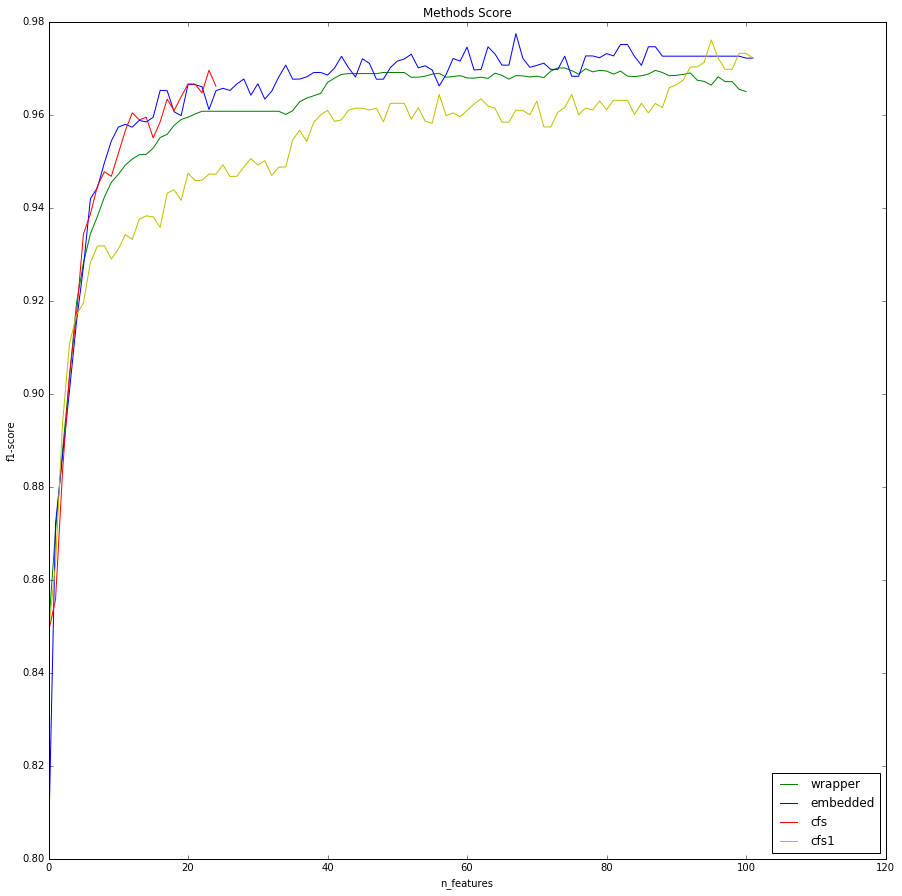

In [147]:
wrapper_fig = plt.figure(figsize=(15, 15))
plt.plot(range(len(wrapper_features)), wrapper_scores, 'g', label="wrapper")
plt.plot(range(len(embedded_features)), embedded_scores, 'b', label="embedded")
plt.plot(range(len(cfs_features)), cfs_scores, 'r', label="cfs")
plt.plot(range(len(cfs1_features)), cfs1_scores, 'y', label="cfs1")

plt.title('Methods Score')

plt.xlabel('n_features')
plt.ylabel('f1-score')
plt.legend(loc='lower right')
cfs_figure.savefig('./hw2_files/scores_all_in_one.png')

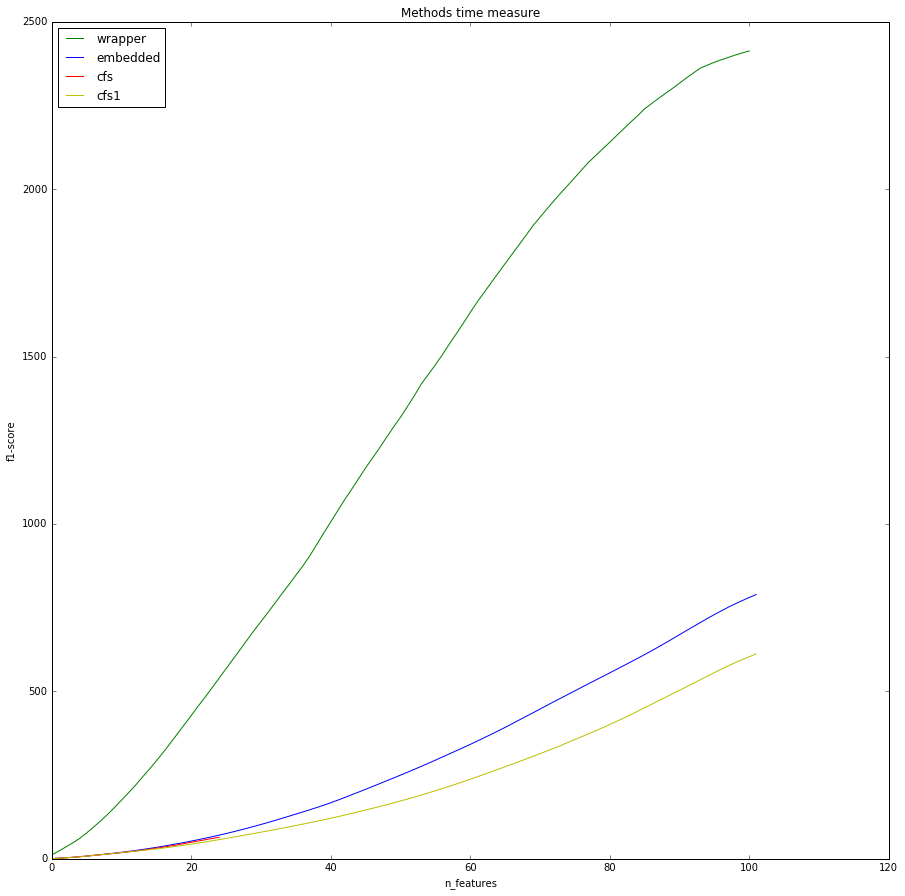

In [148]:
wrapper_fig = plt.figure(figsize=(15, 15))
plt.plot(range(len(wrapper_features)), np.cumsum(wrapper_times), 'g', label="wrapper")
plt.plot(range(len(embedded_features)), np.cumsum(embedded_times), 'b', label="embedded")
plt.plot(range(len(cfs_features)), np.cumsum(cfs_times), 'r', label="cfs")
plt.plot(range(len(cfs1_features)), np.cumsum(cfs1_times), 'y', label="cfs1")
plt.title('Methods time measure')

plt.xlabel('n_features')
plt.ylabel('f1-score')
plt.legend(loc='upper left')
cfs_figure.savefig('./hw2_files/times_all_in_one.png')

# Weighted

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=250)
gbc.fit(x_train, y_train)

In [50]:
gbc = GradientBoostingClassifier(n_estimators=250)
gbc.fit(x_train, y_train)
y_pred = gbc.predict(x_test)
f1_score(y_test, y_pred)

0.98039215686274506

In [51]:
svm_params = {'penalty': 'l1', 'loss': 'squared_hinge', 'C': 1, 'dual': False}

svc = LinearSVC(**svm_params)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
f1_score(y_test, y_pred)

0.96000000000000008

In [52]:
ada_best_params = {'n_estimators': 250, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
ada_Boost_clf = AdaBoostClassifier(**ada_best_params)
ada_Boost_clf.fit(x_train, y_train)
y_pred = ada_Boost_clf.predict(x_test)
f1_score(y_test, y_pred)

0.97220867869332028

(array([ 0.008,  0.004,  0.   ,  0.008,  0.02 ,  0.008,  0.008,  0.008,
         0.02 ,  0.028,  0.008,  0.012,  0.008,  0.008,  0.012,  0.02 ,
         0.008,  0.012,  0.012,  0.02 ,  0.016,  0.02 ,  0.02 ,  0.012,
         0.024,  0.   ,  0.008,  0.012,  0.   ,  0.036,  0.028,  0.016,
         0.008,  0.012,  0.   ,  0.04 ,  0.004,  0.024,  0.016,  0.016,
         0.012,  0.024,  0.004,  0.012,  0.004,  0.004,  0.008,  0.02 ,
         0.016,  0.028,  0.008,  0.012,  0.012,  0.028,  0.008,  0.016,
         0.004,  0.   ,  0.   ,  0.   ,  0.   ,  0.004,  0.004,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.02 ,  0.008,
         0.008,  0.008,  0.004,  0.012,  0.008,  0.   ,  0.004,  0.008,
         0.012,  0.008,  0.004,  0.008,  0.016,  0.008,  0.   ,  0.004,
         0.004,  0.004,  0.008,  0.   ,  0.008,  0.012,  0.   ,  0.004,
         0.012,  0.   ,  0.004,  0.   ,  0.016,  0.016]),
 array([[-0.2160581 ,  0.42516278,  0.5655869 ,  0.        , -2.40802495,
    

In [53]:
from src.weighted_majority import weighted_majority, weighted_predictor

In [54]:
predictors = [gbc, svc, ada_Boost_clf]
weights = weighted_majority(predictors, x_train, y_train)
y_pred = weighted_predictor(x_test, predictors, weights)
f1_score(y_test, y_pred)

0.98039215686274506

In [55]:
weights

array([ 0.00369721,  0.00240318,  0.00101535])

In [115]:
wrapper_features = np.load('./hw2_files/wrapper_gbc.dat.npz')["features"]
wrapper_scores = np.load('./hw2_files/wrapper_gbc.dat.npz')["scores"]
wrapper_times = np.load('./hw2_files/wrapper_gbc.dat.npz')["times"]

In [85]:
embedded_features_weights = np.sum(np.array([gbc.feature_importances_, svc.coef_ / np.sum(svc.coef_), ada_Boost_clf.feature_importances_])*weights, axis=0)[0]

In [90]:
embedded_features_weights = embedded_features_weights.ravel()

In [95]:
embedded_features_weights.ravel()[85]

0.0051070850540854088

array([ 67,  65,  64,  60,  58,  57,  68,  69,  97,  77,  34,  94,  66,
         1,  86,  81,  88,  62,  92,  26,  85,  74,   2,  89,  28,  91,
        40,  20,  50,  99,  45,  21,  79,  83,  25,  84,  42,  90,  39,
         5,  98,  16,  27,  78,  46,  93,  44,  63,   6,  96,  36,  61,
        87,  75,  73,  31,  51,  18,   3,  22,   7,  56,  11,  32,  17,
        14,  59,  76,   0,  72,  30,  82,  19,  24,  33,  38,  41,  13,
        47,  37,  54,  80,  95,  23, 100,  71,  52,  12,  43,  70,  10,
        48,  15,  55,   8,  29,   9,   4,  53,  35,  49, 101])

In [131]:
# embedded_features = np.argsort(gbc.feature_importances_)# np.argsort(embedded_features_weights)[::-1]
embedded_features = np.argsort(embedded_features_weights)[::-1]

In [132]:
_, embedded_scores, embedded_times = fset2scores(embedded_features, x_train, x_test, y_train, y_test)

In [123]:
_, cfs_scores, cfs_times = fset2scores(cfs_features, x_train, x_test, y_train, y_test)

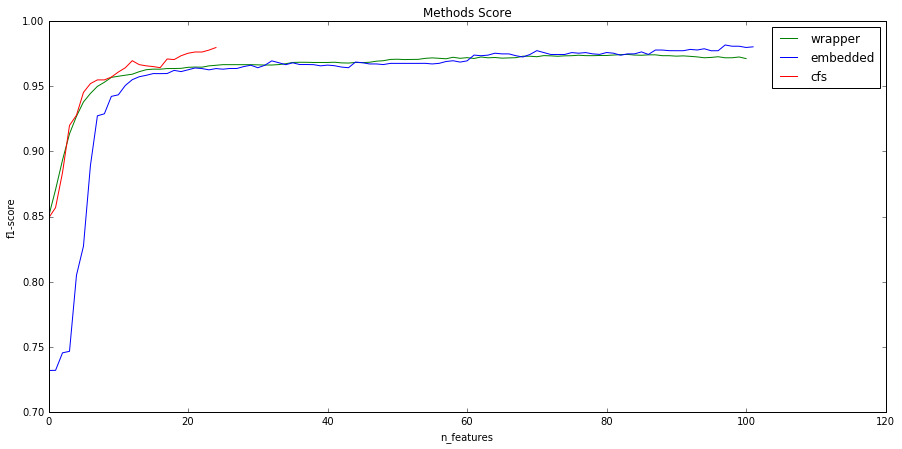

In [133]:
wrapper_fig = plt.figure(figsize=(15, 7))
plt.plot(range(len(wrapper_features)), wrapper_scores, 'g', label="wrapper")
plt.plot(range(len(embedded_features)), embedded_scores, 'b', label="embedded")
plt.plot(range(len(cfs_features)), cfs_scores, 'r', label="cfs")

# plt.plot(range(len(cfs1_features)), cfs1_scores, 'y', label="cfs1")

plt.title('Methods Score')

plt.xlabel('n_features')
plt.ylabel('f1-score')
plt.legend(loc='upper right')